In [1]:
import os
import shutil
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Définir les classes
infected_classes = {
    'hazelnut': ['color', 'print', 'contamination'],
    'capsule': ['contamination'],
    'pill': ['color'],
    'bottle': ['contamination'],
    'leather': ['fold', 'poke']
}

defected_classes = {
    'metal_nut': ['bent', 'broken'],
    'screw': ['manipulated', 'broken'],
    'tile': ['crack'],
    'wood': ['hole'],
    'toothbrush': ['defective']
}

root_dir = 'dataset'  # remplace si ton dossier a un autre nom
final_dir = 'dataset_final'
os.makedirs(final_dir, exist_ok=True)


In [2]:
def collect_data(classes_dict, label_id):
    data = []
    for category, anomalies in classes_dict.items():
        for anomaly in anomalies:
            image_paths = glob(os.path.join(root_dir, category, anomaly, '*.png'))
            for img_path in image_paths:
                # Chemin du masque
                filename = os.path.basename(img_path)
                mask_path = os.path.join(root_dir, category, 'ground_truth', anomaly, filename.replace('.png', '_mask.png'))
                if os.path.exists(mask_path):
                    data.append((img_path, mask_path, label_id))
    return data

infected_data = collect_data(infected_classes, 0)
defected_data = collect_data(defected_classes, 1)
all_data = infected_data + defected_data
print(f"Total d'images valides : {len(all_data)}")


Total d'images valides : 0


In [1]:
import os

root_dir = r'C:\Users\nourchene_pc\Desktop\dataset'

for category in os.listdir(root_dir):
    category_path = os.path.join(root_dir, category)
    if not os.path.isdir(category_path):
        continue
    ground_truth_path = os.path.join(category_path, 'ground_truth')
    if not os.path.exists(ground_truth_path):
        print(f"Pas de ground_truth dans {category}")
        continue
    print(f"\nCatégorie '{category}' - ground_truth contient :")
    for sub in os.listdir(ground_truth_path):
        print(f"  - {sub}")



Catégorie 'bottle' - ground_truth contient :
  - broken_large
  - broken_small
  - contamination

Catégorie 'cable' - ground_truth contient :
  - bent_wire
  - cable_swap
  - combined
  - cut_inner_insulation
  - cut_outer_insulation
  - missing_cable
  - missing_wire
  - poke_insulation

Catégorie 'capsule' - ground_truth contient :
  - crack
  - faulty_imprint
  - poke
  - scratch
  - squeeze

Catégorie 'carpet' - ground_truth contient :
  - color
  - cut
  - hole
  - metal_contamination
  - thread

Catégorie 'grid' - ground_truth contient :
  - bent
  - broken
  - glue
  - metal_contamination
  - thread

Catégorie 'hazelnut' - ground_truth contient :
  - crack
  - cut
  - hole
  - print

Catégorie 'leather' - ground_truth contient :
  - color
  - cut
  - fold
  - glue
  - poke

Catégorie 'metal_nut' - ground_truth contient :
  - bent
  - color
  - flip
  - scratch

Catégorie 'pill' - ground_truth contient :
  - color
  - combined
  - contamination
  - crack
  - faulty_imprint
  - p

In [2]:
import os
anomaly_dir = r'C:\Users\nourchene_pc\Desktop\dataset\grid\ground_truth\metal_contamination'
print(os.listdir(anomaly_dir))


['000_mask.png', '001_mask.png', '002_mask.png', '003_mask.png', '004_mask.png', '005_mask.png', '006_mask.png', '007_mask.png', '008_mask.png', '009_mask.png', '010_mask.png']


In [3]:
import os
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from shutil import copy2

# Chemin vers ton dataset MVTec AD
mvtec_root = r'C:\Users\nourchene_pc\Desktop\dataset'

# Dossiers finaux pour images et labels
final_images_dir = r'C:\Users\nourchene_pc\Desktop\dataset\images'
final_labels_dir = r'C:\Users\nourchene_pc\Desktop\dataset\labels'

for folder in ['train', 'test']:
    os.makedirs(os.path.join(final_images_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(final_labels_dir, folder), exist_ok=True)

# Classes et anomalies (modifie selon ta liste)
infected_classes = {
    'hazelnut': ['print'],
    'capsule': ['poke', 'contamination', 'color', 'fold'],
    'pill': ['contamination'],
    'bottle': ['contamination'],
    'leather': ['contamination', 'color', 'fold', 'poke'],
    'carpet': ['color', 'metal_contamination', 'thread'],
}

defected_classes = {
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'screw': ['manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil', 'rough'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'toothbrush': ['defective'],
    'bottle': ['broken_large', 'broken_small'],
    'carpet': ['cut', 'hole'],
    'pill': ['color', 'combined', 'crack', 'faulty_imprint', 'pill_type', 'scratch'],
    'leather': ['cut', 'fold', 'glue'],
    'transistor': ['bent_lead', 'cut_lead', 'damaged_case', 'misplaced'],
    'zipper': ['broken_teeth', 'combined', 'fabric_border', 'fabric_interior', 'rough', 'split_teeth', 'squeezed_teeth'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination', 'thread'],
    'carpet': ['cut', 'hole', 'metal_contamination', 'thread'],
}

def collect_data_flexible(root_dir, infected_dict, defected_dict):
    data = []

    def add_data(category, anomaly, label_id):
        # Cherche dans train puis test, s'arrête dès qu'il trouve un dossier avec images
        for split in ['train', 'test']:
            imgs_path = os.path.join(root_dir, category, split, anomaly)
            masks_path = os.path.join(root_dir, category, 'ground_truth', anomaly)
            if not os.path.exists(imgs_path):
                continue
            if not os.path.exists(masks_path):
                print(f"⚠️ Dossier masques manquant : {masks_path}")
                return
            imgs = []
            for ext in ['png', 'jpg', 'jpeg']:
                imgs.extend(glob(os.path.join(imgs_path, f'*.{ext}')))
            if len(imgs) == 0:
                continue
            print(f"Collecte {len(imgs)} images dans {imgs_path}")
            for img_path in imgs:
                filename = os.path.basename(img_path)
                name, ext = os.path.splitext(filename)
                mask_filename = f"{name}_mask{ext}"  # suffixe _mask obligatoire
                mask_path = os.path.join(masks_path, mask_filename)
                if os.path.exists(mask_path):
                    data.append((img_path, mask_path, label_id))
                else:
                    print(f"❌ Masque manquant pour {filename} (cherché : {mask_filename})")
            break

    for category, anomalies in infected_dict.items():
        for anomaly in anomalies:
            add_data(category, anomaly, 0)

    for category, anomalies in defected_dict.items():
        for anomaly in anomalies:
            add_data(category, anomaly, 1)

    return data

def mask_to_yolo_bbox(mask_path, label_id):
    mask = Image.open(mask_path).convert('L')
    mask = mask.point(lambda p: p > 128 and 255)
    bbox = mask.getbbox()
    if bbox is None:
        return None
    w, h = mask.size
    x_center = (bbox[0] + bbox[2]) / 2 / w
    y_center = (bbox[1] + bbox[3]) / 2 / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return f"{label_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

all_data = collect_data_flexible(mvtec_root, infected_classes, defected_classes)
print(f"Total images valides collectées : {len(all_data)}")

if len(all_data) == 0:
    raise ValueError("Aucune donnée collectée ! Vérifie les chemins et la structure du dataset.")

train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)
print(f"Split : {len(train_data)} train, {len(test_data)} test")

def save_dataset(data, split):
    for i, (img_path, mask_path, label_id) in enumerate(data):
        ext = os.path.splitext(img_path)[1]
        img_name = f"{split}_{i:05d}{ext}"
        label_name = f"{split}_{i:05d}.txt"

        copy2(img_path, os.path.join(final_images_dir, split, img_name))

        yolo_label = mask_to_yolo_bbox(mask_path, label_id)
        if yolo_label is None:
            print(f"⚠️ Pas de bbox pour {mask_path}, label ignoré")
            continue

        label_path = os.path.join(final_labels_dir, split, label_name)
        with open(label_path, 'w') as f:
            f.write(yolo_label)

save_dataset(train_data, 'train')
save_dataset(test_data, 'test')

print("✅ Dataset YOLO final créé dans 'dataset_final/' avec 2 classes (infected=0, defected=1)")


Collecte 17 images dans C:\Users\nourchene_pc\Desktop\dataset\hazelnut\test\print
Collecte 21 images dans C:\Users\nourchene_pc\Desktop\dataset\capsule\test\poke
Collecte 21 images dans C:\Users\nourchene_pc\Desktop\dataset\pill\test\contamination
Collecte 21 images dans C:\Users\nourchene_pc\Desktop\dataset\bottle\test\contamination
Collecte 19 images dans C:\Users\nourchene_pc\Desktop\dataset\leather\test\color
Collecte 17 images dans C:\Users\nourchene_pc\Desktop\dataset\leather\test\fold
Collecte 18 images dans C:\Users\nourchene_pc\Desktop\dataset\leather\test\poke
Collecte 19 images dans C:\Users\nourchene_pc\Desktop\dataset\carpet\test\color
Collecte 17 images dans C:\Users\nourchene_pc\Desktop\dataset\carpet\test\metal_contamination
Collecte 19 images dans C:\Users\nourchene_pc\Desktop\dataset\carpet\test\thread
Collecte 25 images dans C:\Users\nourchene_pc\Desktop\dataset\metal_nut\test\bent
Collecte 22 images dans C:\Users\nourchene_pc\Desktop\dataset\metal_nut\test\color
Col

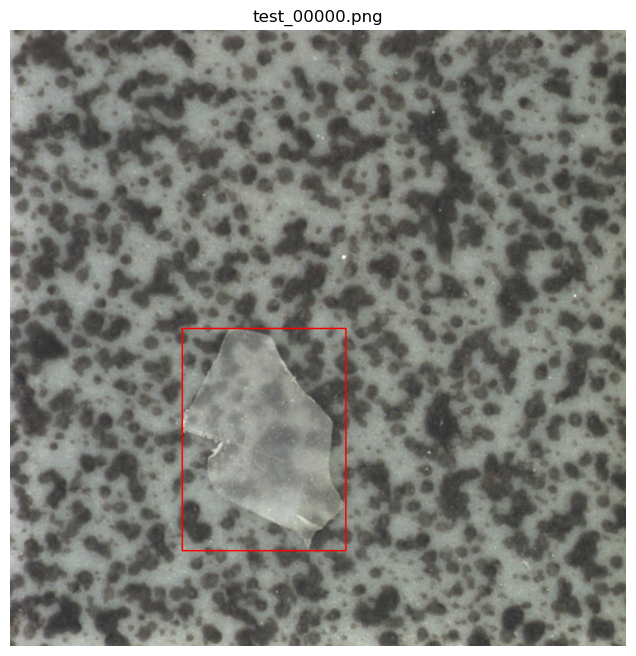

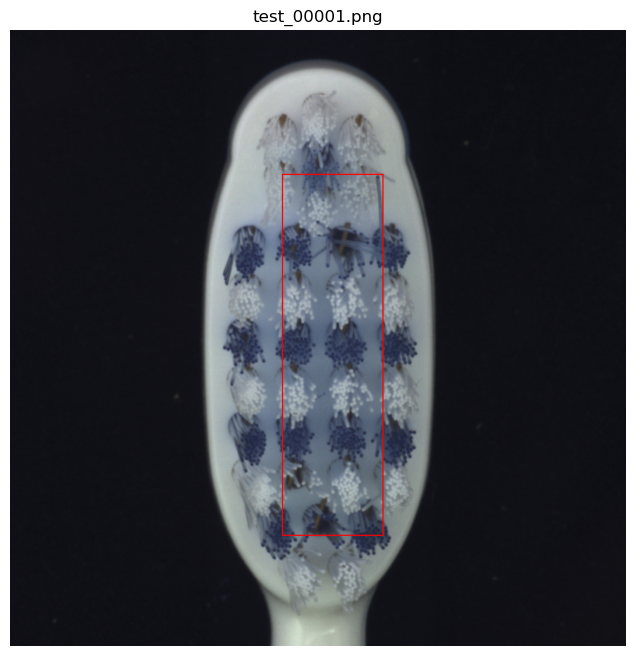

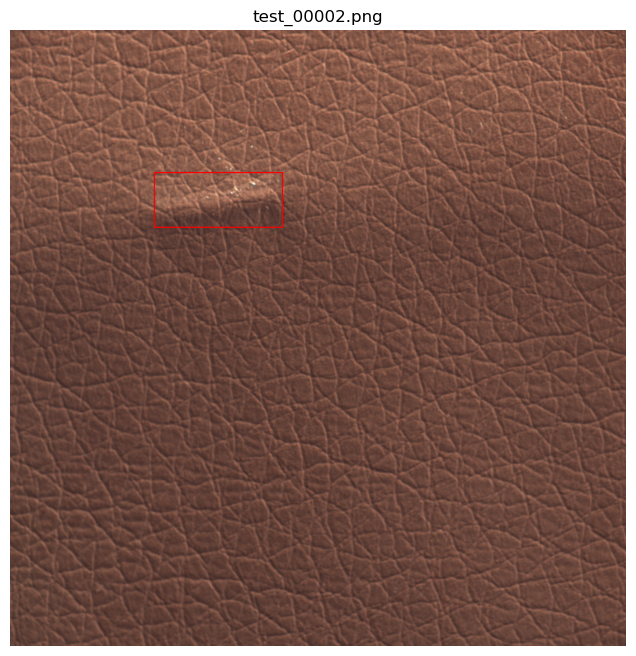

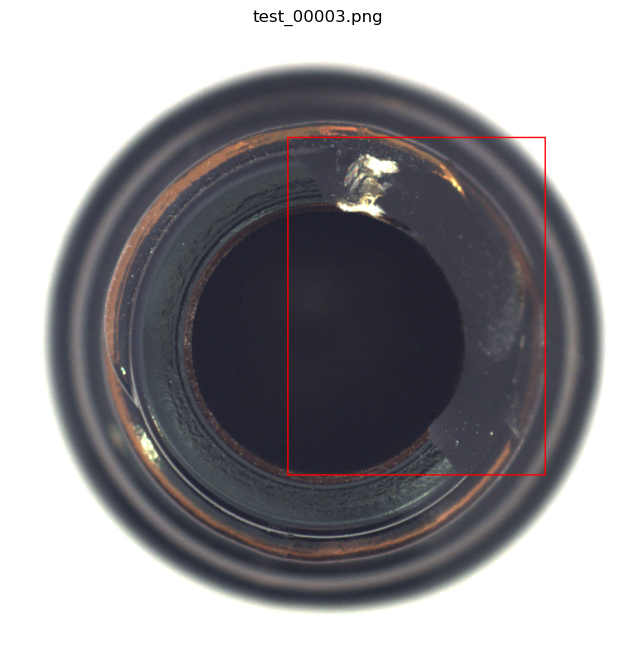

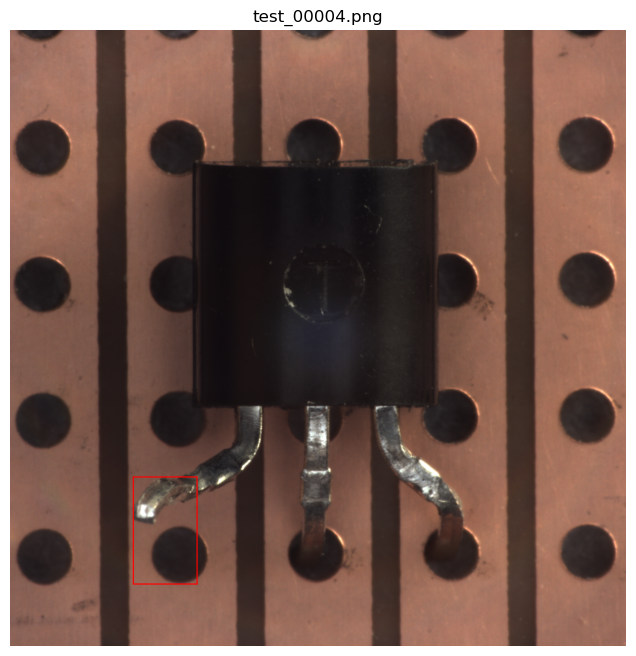

In [4]:
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Chemin vers les dossiers images et labels (change si besoin)
images_dir = r'C:\Users\nourchene_pc\Desktop\dataset\images\test'
labels_dir = r'C:\Users\nourchene_pc\Desktop\dataset\labels\test'

def yolo_to_bbox(label_line, img_width, img_height):
    # Format YOLO : class x_center y_center width height (tout normalisé 0-1)
    parts = label_line.strip().split()
    if len(parts) != 5:
        return None
    _, x_c, y_c, w, h = map(float, parts)
    x1 = (x_c - w/2) * img_width
    y1 = (y_c - h/2) * img_height
    x2 = (x_c + w/2) * img_width
    y2 = (y_c + h/2) * img_height
    return [x1, y1, x2, y2]

def display_sample_images(num_samples=5):
    all_images = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    samples = all_images[:num_samples]

    for img_name in samples:
        img_path = os.path.join(images_dir, img_name)
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_name)

        img = Image.open(img_path)
        draw = ImageDraw.Draw(img)
        w, h = img.size

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    bbox = yolo_to_bbox(line, w, h)
                    if bbox:
                        draw.rectangle(bbox, outline='red', width=2)
        
        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.title(img_name)
        plt.axis('off')
        plt.show()

# Affiche 5 images avec leurs bounding boxes
display_sample_images(5)


In [19]:
yaml_content = """
train: C:/Users/nourchene_pc/Desktop/dataset_final/images/train
val: C:/Users/nourchene_pc/Desktop/dataset_final/images/test

nc: 2
names: ['infected', 'defected']
"""

with open('dataset.yaml', 'w') as f:
    f.write(yaml_content)

print("Fichier dataset_final.yaml créé avec succès !")


Fichier dataset_final.yaml créé avec succès !


In [6]:
from ultralytics import YOLO

# Charger le modèle pré-entraîné
model = YOLO('yolov8n.pt')

# Lancer l'entraînement 
model.train(
    data='dataset_final.yaml',  
    epochs=10,                  
    imgsz=640,                  
    batch=16,                   
    name='yolov8_classifier_infected_defected'  
)


New https://pypi.org/project/ultralytics/8.3.170 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.156  Python-3.11.5 torch-2.6.0+cpu CPU (Intel Core(TM) i5-1035G1 1.00GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_final.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_classifier_infected_defected3, nbs=64, nms=False,

KeyboardInterrupt: 

In [7]:
import os

# 🛠️ Remplace ce chemin par le tien si besoin
images_path = 'C:/Users/nourchene_pc/Desktop/dataset_final/images/train'
labels_path = 'C:/Users/nourchene_pc/Desktop/dataset_final/labels/train'

# 📦 Fichiers images et labels
image_files = [os.path.splitext(f)[0] for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
label_files = [os.path.splitext(f)[0] for f in os.listdir(labels_path) if f.endswith('.txt')]

# 📊 Statistiques
image_set = set(image_files)
label_set = set(label_files)

images_without_labels = image_set - label_set
labels_without_images = label_set - image_set

print(f"📊 Nombre d'images : {len(image_files)}")
print(f"📊 Nombre de labels : {len(label_files)}")

print(f"📦 Images sans label : {len(images_without_labels)}")
if images_without_labels:
    print("🔎 Exemples images sans label :", list(images_without_labels)[:5])

print(f"📦 Labels sans image : {len(labels_without_images)}")
if labels_without_images:
    print("🔎 Exemples labels sans image :", list(labels_without_images)[:5])


📊 Nombre d'images : 9711
📊 Nombre de labels : 1149
📦 Images sans label : 8562
🔎 Exemples images sans label : ['Households_000000002106_jpg.rf.66216acd924d8ff9b1e0cb18e785ce8b', 'zipper_028', 'screw_073', 'Households_000000035222_jpg.rf.073f76ae54f49d145b580737551ccbcd', 'capsule_105']
📦 Labels sans image : 0


In [8]:
import os
import random
import shutil

# === PARAMÈTRES À MODIFIER SI BESOIN ===
src_dataset = "dataset"
dst_dataset = "dataset_balanced"
splits = ["train", "val"]  # on équilibre les deux


In [9]:
def copy_image_and_label(image_name, img_dir, label_dir, dst_img_dir, dst_label_dir, has_label=True):
    # Copier image
    src_img_path = os.path.join(img_dir, image_name)
    dst_img_path = os.path.join(dst_img_dir, image_name)
    shutil.copy2(src_img_path, dst_img_path)

    # Générer label
    label_file = image_name.rsplit(".", 1)[0] + ".txt"
    dst_label_path = os.path.join(dst_label_dir, label_file)

    if has_label:
        src_label_path = os.path.join(label_dir, label_file)
        if os.path.exists(src_label_path):
            shutil.copy2(src_label_path, dst_label_path)
    else:
        # Label vide pour les saines
        with open(dst_label_path, "w") as f:
            pass


In [13]:
import os
import random
import shutil

# Chemins sources
src_dataset = r"C:\Users\nourchene_pc\Desktop\dataset"
dst_dataset = r"C:\Users\nourchene_pc\Desktop\dataset_balanced"

splits = ["train", "test"]

def copy_image_and_label(filename, img_dir, label_dir, dst_img_dir, dst_label_dir, has_label=True):
    # Copier l'image
    shutil.copy2(os.path.join(img_dir, filename), os.path.join(dst_img_dir, filename))
    if has_label:
        # Copier le label txt correspondant
        label_file = filename.rsplit('.', 1)[0] + ".txt"
        shutil.copy2(os.path.join(label_dir, label_file), os.path.join(dst_label_dir, label_file))
    else:
        # Créer un fichier label txt vide si l'image est saine (sans anomalie)
        label_file = filename.rsplit('.', 1)[0] + ".txt"
        open(os.path.join(dst_label_dir, label_file), 'w').close()

for split in splits:
    print(f"\n📂 Split : {split}")

    img_dir = os.path.join(src_dataset, "images", split)
    label_dir = os.path.join(src_dataset, "labels", split)

    dst_img_dir = os.path.join(dst_dataset, "images", split)
    dst_label_dir = os.path.join(dst_dataset, "labels", split)

    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_label_dir, exist_ok=True)

    # Liste des images avec label (anomalie)
    images_with_labels = []
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            base = label_file.replace(".txt", "")
            for ext in [".jpg", ".png"]:
                image_path = os.path.join(img_dir, base + ext)
                if os.path.exists(image_path):
                    images_with_labels.append(base + ext)
                    break

    # Toutes les images dans img_dir
    all_images = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]

    # Images sans label (saines)
    images_without_labels = list(set(all_images) - set(images_with_labels))

    nb_anomalies = len(images_with_labels)
    nb_saines = len(images_without_labels)

    print(f"📊 Anomalies conservées : {nb_anomalies}")
    print(f"📊 Images saines disponibles : {nb_saines}")

    # Échantillonnage équilibré : on prend autant d'images saines que d'anomalies
    sampled_good = random.sample(images_without_labels, min(nb_anomalies, nb_saines))

    print(f"📊 Images saines sélectionnées : {len(sampled_good)}")

    # Copier anomalies
    for img in images_with_labels:
        copy_image_and_label(img, img_dir, label_dir, dst_img_dir, dst_label_dir, has_label=True)

    # Copier images saines avec fichier label vide
    for img in sampled_good:
        copy_image_and_label(img, img_dir, label_dir, dst_img_dir, dst_label_dir, has_label=False)

print("\n✅ Dataset équilibré généré dans : 'dataset_balanced/'")



📂 Split : train
📊 Anomalies conservées : 862
📊 Images saines disponibles : 0
📊 Images saines sélectionnées : 0

📂 Split : test
📊 Anomalies conservées : 216
📊 Images saines disponibles : 0
📊 Images saines sélectionnées : 0

✅ Dataset équilibré généré dans : 'dataset_balanced/'


In [14]:
import os

label_dir = r"C:\Users\nourchene_pc\Desktop\dataset\labels\train"

txt_files = [f for f in os.listdir(label_dir) if f.endswith(".txt")]
print(f"Nombre de fichiers .txt dans labels/train : {len(txt_files)}")

# Affiche quelques exemples
print("Exemples de fichiers .txt :", txt_files[:10])


Nombre de fichiers .txt dans labels/train : 862
Exemples de fichiers .txt : ['train_00000.txt', 'train_00001.txt', 'train_00002.txt', 'train_00003.txt', 'train_00004.txt', 'train_00005.txt', 'train_00006.txt', 'train_00007.txt', 'train_00008.txt', 'train_00009.txt']


In [15]:
import os

img_dir = r"C:\Users\nourchene_pc\Desktop\dataset\images\train"
label_dir = r"C:\Users\nourchene_pc\Desktop\dataset\labels\train"

# Liste des bases noms des fichiers labels (sans extension)
labels_bases = [f.replace(".txt", "") for f in os.listdir(label_dir) if f.endswith(".txt")]

# Images dans le dossier images/train
images = [f for f in os.listdir(img_dir) if f.endswith((".jpg", ".png"))]

# Images sans label (donc saines)
images_saines = [img for img in images if os.path.splitext(img)[0] not in labels_bases]

print(f"Nombre d'images sans label (saines) dans train : {len(images_saines)}")
print("Exemples d'images saines :", images_saines[:10])


Nombre d'images sans label (saines) dans train : 0
Exemples d'images saines : []


In [16]:
import os
from collections import Counter

# Chemins à adapter selon ta structure
img_train_dir = r"C:\Users\nourchene_pc\Desktop\dataset\images\train"
label_train_dir = r"C:\Users\nourchene_pc\Desktop\dataset\labels\train"

# Lister images dans train
all_images = [f for f in os.listdir(img_train_dir) if f.endswith(('.jpg', '.png'))]
print(f"Total images train : {len(all_images)}")

# Lister fichiers label
label_files = [f for f in os.listdir(label_train_dir) if f.endswith(".txt")]
print(f"Total labels train : {len(label_files)}")

# Images avec label (avec fichier txt correspondant)
images_with_label = [f.replace('.txt','') for f in label_files]

# Images sans label
images_without_label = [f for f in all_images if os.path.splitext(f)[0] not in images_with_label]
print(f"Images sans label (saines) : {len(images_without_label)}")

# Analyser la répartition des classes dans les labels
class_counts = Counter()

for lbl_file in label_files:
    lbl_path = os.path.join(label_train_dir, lbl_file)
    with open(lbl_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.strip():
                cls_id = line.strip().split()[0]
                class_counts[cls_id] += 1

print("\nRépartition des classes dans labels/train :")
for cls_id, count in class_counts.items():
    print(f"Classe {cls_id} : {count} occurrences")


Total images train : 862
Total labels train : 862
Images sans label (saines) : 0

Répartition des classes dans labels/train :
Classe 1 : 710 occurrences
Classe 0 : 152 occurrences


In [17]:
total = 710 + 152
weight_infected = total / (2 * 152)  # Classe 0
weight_defected = total / (2 * 710)  # Classe 1
cls_weights = [weight_infected, weight_defected]
print(cls_weights)


[2.835526315789474, 0.6070422535211267]


In [22]:
import os
import random
from PIL import Image, ImageOps
import shutil

# Chemins du dataset original et du dataset rééquilibré
src_img_dir = "C:/Users/nourchene_pc/Desktop/dataset/images/train"
src_lbl_dir = "C:/Users/nourchene_pc/Desktop/dataset/labels/train"

dst_img_dir = "C:/Users/nourchene_pc/Desktop/dataset_balanced/images/train"
dst_lbl_dir = "C:/Users/nourchene_pc/Desktop/dataset_balanced/labels/train"

os.makedirs(dst_img_dir, exist_ok=True)
os.makedirs(dst_lbl_dir, exist_ok=True)

# Lecture des labels pour compter occurrences par classe
class_counts = {}
image_labels = {}

for label_file in os.listdir(src_lbl_dir):
    if not label_file.endswith(".txt"):
        continue
    path_lbl = os.path.join(src_lbl_dir, label_file)
    with open(path_lbl, "r") as f:
        lines = f.readlines()

    classes_in_img = []
    for line in lines:
        cls_id = int(line.strip().split()[0])
        classes_in_img.append(cls_id)
        class_counts[cls_id] = class_counts.get(cls_id, 0) + 1

    image_labels[label_file.replace(".txt", "")] = classes_in_img

print("Distribution classes dans train :", class_counts)

# Trouver la classe majoritaire et minoritaire
max_count = max(class_counts.values())
min_count = min(class_counts.values())
min_class = min(class_counts, key=class_counts.get)

print(f"Classe minoritaire : {min_class} avec {min_count} occurrences")
print(f"Classe majoritaire : {max(class_counts, key=class_counts.get)} avec {max_count} occurrences")

# Copier toutes les images/labels d'origine dans le dataset équilibré
for img_name in image_labels.keys():
    # Extensions possibles
    img_path = None
    for ext in [".jpg", ".png"]:
        candidate = os.path.join(src_img_dir, img_name + ext)
        if os.path.exists(candidate):
            img_path = candidate
            break
    if img_path is None:
        continue
    shutil.copy(img_path, os.path.join(dst_img_dir, os.path.basename(img_path)))
    shutil.copy(os.path.join(src_lbl_dir, img_name + ".txt"), os.path.join(dst_lbl_dir, img_name + ".txt"))

print("Images d'origine copiées dans dataset équilibré.")

# Fonction augmentation simple : rotation 90°, flip horizontal
def augment_image(img):
    # Choix aléatoire parmi plusieurs augmentations
    aug_type = random.choice(["rotate", "flip"])
    if aug_type == "rotate":
        return img.rotate(90, expand=True)
    elif aug_type == "flip":
        return ImageOps.mirror(img)
    else:
        return img

# On duplique et augmente les images de la classe minoritaire jusqu'à équilibre
imgs_to_augment = [img_name for img_name, classes in image_labels.items() if min_class in classes]

print(f"Nombre d'images à augmenter (classe {min_class}): {len(imgs_to_augment)}")

current_count = class_counts[min_class]
idx = 0
while current_count < max_count:
    img_name = imgs_to_augment[idx % len(imgs_to_augment)]

    # Charger image
    for ext in [".jpg", ".png"]:
        img_path = os.path.join(src_img_dir, img_name + ext)
        if os.path.exists(img_path):
            break
    img = Image.open(img_path)

    # Augmenter
    img_aug = augment_image(img)

    # Nouveau nom
    new_img_name = f"{img_name}_aug{idx}"

    # Sauvegarder image augmentée
    ext = os.path.splitext(img_path)[1]
    img_aug.save(os.path.join(dst_img_dir, new_img_name + ext))

    # Copier label (identique, car bbox reste la même dans cette augmentation simple)
    shutil.copy(os.path.join(src_lbl_dir, img_name + ".txt"), os.path.join(dst_lbl_dir, new_img_name + ".txt"))

    current_count += sum([1 for c in image_labels[img_name] if c == min_class])
    idx += 1

print(f"Augmentation terminée. Nouvelle distribution approximative :")
print(f"{min_class} ≈ {current_count}, majoritaire ≈ {max_count}")
print(f"Dataset équilibré disponible dans : {dst_img_dir} et {dst_lbl_dir}")


Distribution classes dans train : {1: 710, 0: 152}
Classe minoritaire : 0 avec 152 occurrences
Classe majoritaire : 1 avec 710 occurrences
Images d'origine copiées dans dataset équilibré.
Nombre d'images à augmenter (classe 0): 152
Augmentation terminée. Nouvelle distribution approximative :
0 ≈ 710, majoritaire ≈ 710
Dataset équilibré disponible dans : C:/Users/nourchene_pc/Desktop/dataset_balanced/images/train et C:/Users/nourchene_pc/Desktop/dataset_balanced/labels/train


In [26]:
yaml_content = """
train: C:/Users/nourchene_pc/Desktop/dataset_balanced/images/train
val: C:/Users/nourchene_pc/Desktop/dataset_balanced/images/val

nc: 2
names: ['infected', 'defected']
"""

with open('dataset_balanced.yaml', 'w') as f:
    f.write(yaml_content)

print("Fichier dataset_balanced.yaml créé avec succès !")


Fichier dataset_balanced.yaml créé avec succès !


In [29]:
import os
import shutil

def copy_files(img_list, src_img, src_label, dst_img, dst_label):
    os.makedirs(dst_img, exist_ok=True)
    os.makedirs(dst_label, exist_ok=True)
    
    for img_file in img_list:
        # Copier l'image
        src_img_path = os.path.join(src_img, img_file)
        dst_img_path = os.path.join(dst_img, img_file)
        shutil.copy2(src_img_path, dst_img_path)
        
        # Nom du fichier label correspondant
        label_file = os.path.splitext(img_file)[0] + ".txt"
        src_label_path = os.path.join(src_label, label_file)
        dst_label_path = os.path.join(dst_label, label_file)
        
        # Copier le label s'il existe, sinon afficher un avertissement
        if os.path.exists(src_label_path):
            shutil.copy2(src_label_path, dst_label_path)
        else:
            print(f"⚠️ Label manquant pour {img_file} -> {label_file}")

# Exemple d'utilisation :

# Répertoires source
src_img_dir = "C:/Users/nourchene_pc/Desktop/dataset_balanced/images/train"
src_label_dir = "C:/Users/nourchene_pc/Desktop/dataset_balanced/labels/train"

# Répertoires destination
dst_img_train = "C:/Users/nourchene_pc/Desktop/dataset_final/images/train"
dst_label_train = "C:/Users/nourchene_pc/Desktop/dataset_final/labels/train"

# Liste des images à copier (par exemple tous les fichiers .jpg et .png dans src_img_dir)
train_imgs = [f for f in os.listdir(src_img_dir) if f.endswith((".jpg", ".png"))]

# Copier fichiers images et labels
copy_files(train_imgs, src_img_dir, src_label_dir, dst_img_train, dst_label_train)

print(f"\n✅ Copie terminée. {len(train_imgs)} images traitées.")


⚠️ Label manquant pour bottle_005_aug5.png -> bottle_005_aug5.txt

✅ Copie terminée. 1713 images traitées.


In [31]:
yaml_content = """
train: C:/Users/nourchene_pc/Desktop/dataset/images/train
val: C:/Users/nourchene_pc/Desktop/dataset/images/test

nc: 2
names: ['infected', 'defected']
"""

with open("dataset_final.yaml", "w") as f:
    f.write(yaml_content)

print("Fichier dataset_final.yaml créé avec succès !")


Fichier dataset_final.yaml créé avec succès !


In [32]:
from ultralytics import YOLO

# Charger un modèle pré-entrainé
model = YOLO('yolov8n.pt')

# Lancer l'entraînement
model.train(data='dataset_final.yaml', epochs=10, imgsz=640)


New https://pypi.org/project/ultralytics/8.3.170 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.156  Python-3.11.5 torch-2.6.0+cpu CPU (Intel Core(TM) i5-1035G1 1.00GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_final.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, o

train: Scanning C:\Users\nourchene_pc\Desktop\dataset\labels\train... 862 images, 0 backgrounds, 0 corrupt: 100%|██████████| 862/862 [00:03<00:00, 278.02it/s]

train: New cache created: C:\Users\nourchene_pc\Desktop\dataset\labels\train.cache


val: Fast image access  (ping: 0.10.0 ms, read: 181.725.1 MB/s, size: 568.8 KB)


val: Scanning C:\Users\nourchene_pc\Desktop\dataset\labels\test... 216 images, 0 backgrounds, 0 corrupt: 100%|██████████| 216/216 [00:00<00:00, 255.47it/s]

val: New cache created: C:\Users\nourchene_pc\Desktop\dataset\labels\test.cache


Plotting labels to C:\Users\nourchene_pc\runs\detect\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Users\nourchene_pc\runs\detect\train7
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.939      4.707      2.047         14        640: 100%|██████████| 54/54 [06:36<00:00,  7.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:46<00:00,  6.67s/it]

                   all        216        216    0.00209      0.595     0.0188    0.00702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.207      4.476      2.212         14        640: 100%|██████████| 54/54 [06:06<00:00,  6.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:43<00:00,  6.23s/it]

                   all        216        216      0.517     0.0335     0.0104    0.00375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      2.321      4.097      2.437         14        640: 100%|██████████| 54/54 [06:03<00:00,  6.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:39<00:00,  5.58s/it]

                   all        216        216       0.14      0.156     0.0391     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.279      3.686       2.43         13        640: 100%|██████████| 54/54 [05:55<00:00,  6.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:39<00:00,  5.69s/it]

                   all        216        216      0.199     0.0885     0.0567     0.0195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      2.199      3.458      2.348         14        640: 100%|██████████| 54/54 [05:54<00:00,  6.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:37<00:00,  5.40s/it]

                   all        216        216      0.224      0.121     0.0854     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      2.113      3.202      2.275         14        640: 100%|██████████| 54/54 [06:00<00:00,  6.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:36<00:00,  5.28s/it]

                   all        216        216      0.221       0.21      0.115     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G          2      2.965      2.165         13        640: 100%|██████████| 54/54 [05:58<00:00,  6.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:37<00:00,  5.32s/it]

                   all        216        216      0.371      0.208      0.166     0.0749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.911      2.761      2.062         14        640: 100%|██████████| 54/54 [06:24<00:00,  7.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:43<00:00,  6.26s/it]

                   all        216        216       0.38      0.269       0.24       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.775      2.574      1.927         14        640: 100%|██████████| 54/54 [06:37<00:00,  7.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:38<00:00,  5.43s/it]

                   all        216        216      0.391      0.268      0.245      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.693      2.413      1.839         14        640: 100%|██████████| 54/54 [06:07<00:00,  6.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:37<00:00,  5.31s/it]

                   all        216        216      0.473      0.312      0.305       0.17



10 epochs completed in 1.142 hours.
Optimizer stripped from C:\Users\nourchene_pc\runs\detect\train7\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\nourchene_pc\runs\detect\train7\weights\best.pt, 6.2MB

Validating C:\Users\nourchene_pc\runs\detect\train7\weights\best.pt...
Ultralytics 8.3.156  Python-3.11.5 torch-2.6.0+cpu CPU (Intel Core(TM) i5-1035G1 1.00GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:32<00:00,  4.63s/it]


                   all        216        216      0.474      0.311      0.305       0.17
              infected         37         37      0.501      0.243      0.268      0.172
              defected        179        179      0.447      0.379      0.341      0.168
Speed: 3.3ms preprocess, 115.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to C:\Users\nourchene_pc\runs\detect\train7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002B8804069D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [1]:
from ultralytics import YOLO

# Charger un modèle pré-entrainé
model = YOLO('yolov8n.pt')

# Lancer l'entraînement
model.train(data='dataset_final.yaml', epochs=20, imgsz=640)


New https://pypi.org/project/ultralytics/8.3.170 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.156  Python-3.11.5 torch-2.6.0+cpu CPU (Intel Core(TM) i5-1035G1 1.00GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_final.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train12, nbs=64, nms=False, opset=None, optimize=False, 

train: Scanning C:\Users\nourchene_pc\Desktop\dataset\labels\train.cache... 862 images, 0 backgrounds, 0 corrupt: 100%|██████████| 862/862 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 142.827.4 MB/s, size: 568.8 KB)


val: Scanning C:\Users\nourchene_pc\Desktop\dataset\labels\test.cache... 216 images, 0 backgrounds, 0 corrupt: 100%|██████████| 216/216 [00:00<?, ?it/s]


Plotting labels to C:\Users\nourchene_pc\runs\detect\train12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Users\nourchene_pc\runs\detect\train12
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.789       3.78      1.831         26        640: 100%|██████████| 54/54 [08:44<00:00,  9.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:01<00:00,  8.77s/it]

                   all        216        216    0.00165      0.413     0.0288     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.941      3.538       1.93         27        640: 100%|██████████| 54/54 [06:58<00:00,  7.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:47<00:00,  6.76s/it]

                   all        216        216      0.241       0.11     0.0355     0.0118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      2.059      3.415      2.048         29        640: 100%|██████████| 54/54 [06:58<00:00,  7.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:49<00:00,  7.13s/it]

                   all        216        216     0.0866        0.1     0.0175     0.0051



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      2.066      3.228      2.095         27        640: 100%|██████████| 54/54 [06:55<00:00,  7.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:47<00:00,  6.72s/it]

                   all        216        216     0.0613     0.0414    0.00951    0.00274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.996      3.028      2.024         21        640: 100%|██████████| 54/54 [07:28<00:00,  8.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:58<00:00,  8.29s/it]

                   all        216        216       0.17       0.19     0.0643     0.0317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.995      2.921      2.024         28        640: 100%|██████████| 54/54 [08:57<00:00,  9.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:51<00:00,  7.43s/it]

                   all        216        216      0.258      0.196      0.112     0.0418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G       1.91      2.768        1.9         17        640: 100%|██████████| 54/54 [08:15<00:00,  9.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<00:00,  7.84s/it]

                   all        216        216      0.172       0.24     0.0994     0.0445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.861      2.671      1.885         20        640: 100%|██████████| 54/54 [08:06<00:00,  9.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:50<00:00,  7.21s/it]

                   all        216        216      0.331      0.188       0.15     0.0722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.808      2.571      1.858         22        640: 100%|██████████| 54/54 [08:40<00:00,  9.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:46<00:00,  6.62s/it]

                   all        216        216      0.273      0.253      0.154     0.0706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.732      2.401      1.781         19        640: 100%|██████████| 54/54 [09:13<00:00, 10.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<00:00,  7.83s/it]

                   all        216        216       0.31      0.289       0.24      0.125


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      1.738      2.476      1.836         14        640: 100%|██████████| 54/54 [08:55<00:00,  9.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:51<00:00,  7.42s/it]

                   all        216        216      0.439      0.326      0.248      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.692      2.304      1.758         14        640: 100%|██████████| 54/54 [07:03<00:00,  7.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:41<00:00,  5.90s/it]

                   all        216        216      0.264      0.301      0.214      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.573      2.235       1.66         13        640: 100%|██████████| 54/54 [06:41<00:00,  7.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:40<00:00,  5.81s/it]

                   all        216        216       0.31      0.338      0.273      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.541      2.095      1.649         14        640: 100%|██████████| 54/54 [06:48<00:00,  7.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:41<00:00,  5.91s/it]

                   all        216        216      0.329      0.367       0.28      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G        1.5      1.993      1.614         14        640: 100%|██████████| 54/54 [06:53<00:00,  7.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:42<00:00,  6.09s/it]

                   all        216        216      0.264      0.421      0.312      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.459       1.89      1.582         14        640: 100%|██████████| 54/54 [06:59<00:00,  7.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:43<00:00,  6.18s/it]

                   all        216        216      0.368      0.382      0.363      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G        1.4      1.819      1.531         13        640: 100%|██████████| 54/54 [06:56<00:00,  7.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:42<00:00,  6.06s/it]

                   all        216        216      0.394      0.387      0.374      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.357      1.744      1.515         14        640: 100%|██████████| 54/54 [06:36<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:41<00:00,  5.99s/it]

                   all        216        216      0.465      0.363      0.401       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.292      1.667      1.448         14        640: 100%|██████████| 54/54 [06:42<00:00,  7.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:41<00:00,  5.98s/it]

                   all        216        216      0.422      0.459      0.434      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.303      1.634      1.459         14        640: 100%|██████████| 54/54 [08:01<00:00,  8.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:43<00:00,  6.23s/it]

                   all        216        216      0.415      0.478      0.423      0.246



20 epochs completed in 2.804 hours.
Optimizer stripped from C:\Users\nourchene_pc\runs\detect\train12\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\nourchene_pc\runs\detect\train12\weights\best.pt, 6.2MB

Validating C:\Users\nourchene_pc\runs\detect\train12\weights\best.pt...
Ultralytics 8.3.156  Python-3.11.5 torch-2.6.0+cpu CPU (Intel Core(TM) i5-1035G1 1.00GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


                   all        216        216      0.421       0.46      0.433      0.253
              infected         37         37      0.402      0.327      0.367      0.218
              defected        179        179      0.441      0.592      0.499      0.289
Speed: 4.6ms preprocess, 162.9ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to C:\Users\nourchene_pc\runs\detect\train12


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F853FC5410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [4]:
from ultralytics import YOLO
model = YOLO("runs/detect/train12/weights/best.pt")


In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train12/weights/best.pt")
results = model.val(data="dataset_final.yaml")

print("Mean Precision (mp) :", results.box.mp)
print("Mean Recall (mr)    :", results.box.mr)
print("mAP@0.5             :", results.box.map50)
print("mAP@0.5:0.95        :", results.box.map)

results.plot()


In [15]:
from ultralytics import YOLO
import os
import shutil

model = YOLO("runs/detect/train12/weights/best.pt")  # ton modèle entraîné

input_folder = "C:/Users/nourchene_pc/Desktop/dataset/images/test"
infected_folder = "C:/Users/nourchene_pc/Desktop/infected_images"
defected_folder = "C:/Users/nourchene_pc/Desktop/defected_images"

os.makedirs(infected_folder, exist_ok=True)
os.makedirs(defected_folder, exist_ok=True)

for img_name in os.listdir(input_folder):
    if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(input_folder, img_name)
        results = model.predict(source=img_path, conf=0.5)
        classes = results[0].boxes.cls.cpu().numpy() if len(results[0].boxes) > 0 else []
        
        if 0 in classes:  # classe infected (indice 0)
            shutil.copy(img_path, infected_folder)
        elif 1 in classes:  # classe defected (indice 1)
            shutil.copy(img_path, defected_folder)
        else:
            # pas de détection ou autre traitement
            pass

print("Images triées selon leur classe.")



image 1/1 C:\Users\nourchene_pc\Desktop\dataset\images\test\test_00000.png: 640x640 1 defected, 204.5ms
Speed: 7.7ms preprocess, 204.5ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\nourchene_pc\Desktop\dataset\images\test\test_00001.png: 640x640 (no detections), 122.2ms
Speed: 5.5ms preprocess, 122.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\nourchene_pc\Desktop\dataset\images\test\test_00002.png: 640x640 (no detections), 124.0ms
Speed: 6.1ms preprocess, 124.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\nourchene_pc\Desktop\dataset\images\test\test_00003.png: 640x640 2 defecteds, 105.1ms
Speed: 5.6ms preprocess, 105.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\nourchene_pc\Desktop\dataset\images\test\test_00004.png: 640x640 (no detections), 98.8ms
Speed: 5.1ms preprocess, 98.8ms inference, 1.2ms postprocess per ima

In [16]:
from ultralytics import YOLO
import cv2
import os

model = YOLO("runs/detect/train12/weights/best.pt")
infected_folder = "C:/Users/nourchene_pc/Desktop/infected_images"

seuil_rejet = 5.0  # % d'infection au-delà duquel on rejette

for img_name in os.listdir(infected_folder):
    if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(infected_folder, img_name)
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        results = model.predict(source=img_path, conf=0.5)
        boxes = results[0].boxes.xyxy.cpu().numpy()  # coordonnées des boîtes
        classes = results[0].boxes.cls.cpu().numpy()

        # Filtrer uniquement les boîtes de classe 'infected' (indice 0)
        infected_boxes = [boxes[i] for i, c in enumerate(classes) if c == 0]

        total_area = w * h
        infected_area = 0

        for box in infected_boxes:
            x1, y1, x2, y2 = box
            box_area = (x2 - x1) * (y2 - y1)
            infected_area += box_area

        pourcentage_infection = (infected_area / total_area) * 100

        if pourcentage_infection > seuil_rejet:
            decision = "REJETÉ"
        else:
            decision = "RECYCLÉ"

        print(f"{img_name} - Infection: {pourcentage_infection:.2f}% - Décision: {decision}")



image 1/1 C:\Users\nourchene_pc\Desktop\infected_images\test_00047.png: 640x640 1 infected, 98.8ms
Speed: 6.3ms preprocess, 98.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
test_00047.png - Infection: 0.46% - Décision: RECYCLÉ

image 1/1 C:\Users\nourchene_pc\Desktop\infected_images\test_00101.png: 640x640 1 infected, 1 defected, 89.4ms
Speed: 5.2ms preprocess, 89.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
test_00101.png - Infection: 1.50% - Décision: RECYCLÉ

image 1/1 C:\Users\nourchene_pc\Desktop\infected_images\test_00125.png: 640x640 1 infected, 91.4ms
Speed: 5.4ms preprocess, 91.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
test_00125.png - Infection: 0.30% - Décision: RECYCLÉ

image 1/1 C:\Users\nourchene_pc\Desktop\infected_images\test_00146.png: 640x640 1 infected, 1 defected, 96.8ms
Speed: 5.2ms preprocess, 96.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
test_00146.png - Infection

In [17]:
pip install pyodbc


Note: you may need to restart the kernel to use updated packages.


In [18]:
import pyodbc
import os

try:
    # Connexion à ta base SQL Server datasetF
    conn = pyodbc.connect(
        'DRIVER={ODBC Driver 17 for SQL Server};'
        'SERVER=localhost;'
        'DATABASE=dataset;'
        'Trusted_Connection=yes;'
    )
    cursor = conn.cursor()
    print("✅ Connexion réussie à SQL Server.")

    # Création de la table "dataset" si elle n'existe pas
    cursor.execute("""
    IF OBJECT_ID('dbo.dataset', 'U') IS NULL
    CREATE TABLE dbo.dataset (
        id INT IDENTITY(1,1) PRIMARY KEY,
        image_name NVARCHAR(255),
        chemin_image NVARCHAR(500),
        classe_defaut NVARCHAR(50),
        taux_defaut FLOAT,
        confiance FLOAT,
        action NVARCHAR(50)
    )
    """)
    conn.commit()

    # Parcours des images dans train et test du dataset
    for split in ['train', 'test']:
        image_dir = f'C:/Users/nourchene_pc/Desktop/dataset/images/{split}'
        if not os.path.exists(image_dir):
            print(f"⚠️ Le dossier {image_dir} n'existe pas.")
            continue

        for file in os.listdir(image_dir):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                chemin_image = os.path.join(image_dir, file)
                nom_image = file

                # Ici tu peux remplacer cette logique par la vraie classe issue de ta détection YOLO
                # Pour l'instant, on suppose que tu as un moyen de la déterminer, sinon par défaut :
                # Par exemple si tu as une liste des images infectées, tu peux vérifier ici
                # Sinon ici juste mettre 'unknown' ou 'normal'
                classe_defaut = 'unknown'
                taux_defaut = 0.0
                confiance = 0.0
                action = 'unknown'

                # Exemples : tu peux ajouter ici ta logique pour mettre à jour ces valeurs
                # Par ex: si dans un dictionnaire ou csv tu as les résultats des prédictions
                # classe_defaut = 'infected' ou 'defected' selon ta détection
                # taux_defaut = 0.46  # valeur extraite de ta détection YOLO
                # confiance = 0.87    # confiance de la prédiction
                # action = 'rejeter' ou 'recycler'

                # Insertion dans la table SQL
                cursor.execute("""
                    INSERT INTO dbo.dataset
                    (image_name, chemin_image, classe_defaut, taux_defaut, confiance, action)
                    VALUES (?, ?, ?, ?, ?, ?)
                """, nom_image, chemin_image, classe_defaut, taux_defaut, confiance, action)

    conn.commit()
    print("✅ Toutes les images ont été insérées avec succès.")

except Exception as e:
    print("❌ Erreur :", e)

finally:
    if 'conn' in locals():
        conn.close()
        print("✅ Connexion fermée")


✅ Connexion réussie à SQL Server.
✅ Toutes les images ont été insérées avec succès.
✅ Connexion fermée


In [22]:
import os
import pyodbc
from ultralytics import YOLO
from PIL import Image
import pandas as pd

# 1) Connexion à SQL Server
conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=localhost;'
    'DATABASE=dataset;'
    'Trusted_Connection=yes;'
)
cursor = conn.cursor()
print("✅ Connexion SQL réussie.")

# 2) Charger le modèle entraîné
model = YOLO("runs/detect/train12/weights/best.pt")

# 3) Paramètres
image_folder = "C:/Users/nourchene_pc/Desktop/infected_images"
threshold_percent = 5.0  # seuil de rejet
results_list = []        # pour stocker en mémoire

# 4) Boucle sur les images
for filename in os.listdir(image_folder):
    if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue
    image_path = os.path.join(image_folder, filename)

    # 4.1) Détection
    res = model(image_path)[0]
    boxes = res.boxes.xyxy.cpu().numpy()
    classes = res.boxes.cls.cpu().numpy()
    scores = res.boxes.conf.cpu().numpy()

    # 4.2) Calcul de la surface totale image
    img = Image.open(image_path)
    img_area = img.width * img.height

    # 4.3) Calcul du pourcentage d'infection
    infected_area = 0.0
    for box, cls in zip(boxes, classes):
        if int(cls) == 0:  # 0 = infected
            x1, y1, x2, y2 = box
            infected_area += (x2 - x1) * (y2 - y1)
    infection_percent = (infected_area / img_area) * 100

    # 4.4) Classe, confiance, décision
    infection_class = "infected" if infection_percent > 0 else "none"
    confiance = float(max(scores)) if len(scores) > 0 else 0.0
    decision = "REJETER" if infection_percent > threshold_percent else "RECYCLER"

    print(f"{filename} — %infection={infection_percent:.2f} — conf={confiance:.2f} — {decision}")

    # 4.5) Insertion SQL
    cursor.execute("""
        INSERT INTO dataset
          (image_name, chemin_image, infection_class, infection_percent, confiance, decision)
        VALUES (?, ?, ?, ?, ?, ?)
    """, filename, image_path, infection_class, infection_percent, confiance, decision)
    conn.commit()

    # 4.6) Stockage en liste
    results_list.append({
        "image_name": filename,
        "infection_class": infection_class,
        "infection_percent": infection_percent,
        "confiance": confiance,
        "decision": decision
    })

# 5) Fermer la connexion
cursor.close()
conn.close()
print("✅ Insertion terminée et connexion fermée.")

# 6) Création d'un DataFrame Pandas pour analyse / dashboard
df = pd.DataFrame(results_list)
print(df.head())


✅ Connexion SQL réussie.

image 1/1 C:\Users\nourchene_pc\Desktop\infected_images\test_00003.png: 640x640 3 defecteds, 93.8ms
Speed: 6.7ms preprocess, 93.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
test_00003.png — %infection=0.00 — conf=0.56 — RECYCLER

image 1/1 C:\Users\nourchene_pc\Desktop\infected_images\test_00005.png: 640x640 1 defected, 90.3ms
Speed: 4.7ms preprocess, 90.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
test_00005.png — %infection=0.00 — conf=0.65 — RECYCLER

image 1/1 C:\Users\nourchene_pc\Desktop\infected_images\test_00008.png: 640x640 1 defected, 92.4ms
Speed: 4.3ms preprocess, 92.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
test_00008.png — %infection=0.00 — conf=0.33 — RECYCLER

image 1/1 C:\Users\nourchene_pc\Desktop\infected_images\test_00024.png: 640x640 2 defecteds, 94.1ms
Speed: 5.2ms preprocess, 94.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
test_00024.png — 

In [23]:
fig = px.pie(df, names='decision', title='Répartition des décisions')
fig.show()


In [24]:
fig = px.histogram(df, x="infection_percent", nbins=30,
                   title="Distribution du pourcentage d'infection")
fig.update_layout(xaxis_title="Infection (%)", yaxis_title="Nombre d'images")
fig.show()


In [26]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df["image_name"],
    y=df["infection_percent"],
    name="Infection %",
    marker_color="crimson"
))

fig.add_trace(go.Bar(
    x=df["image_name"],
    y=df["confiance"],
    name="Confiance",
    marker_color="green"
))

fig.update_layout(
    title="Infection % vs Confiance par image",
    xaxis_title="Nom d'image",
    yaxis_title="Valeur",
    barmode='group'
)
fig.show()
